In [37]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from IPython.display import HTML, Image


%matplotlib inline
plt.style.use('seaborn-white')
import warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_1081516/309985076.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [45]:
def regularized_mse(X, y, W, l2=10):
    """
    Computes the regularized mean squared error (MSE) for linear regression with L2 regularization (Ridge Regression).

    Parameters:
    X (numpy.ndarray): The input feature matrix of shape (num_samples, num_features).
    y (numpy.ndarray): The output/target values vector of shape (num_samples, 1).
    W (numpy.ndarray): The weights/parameters vector of shape (num_features, 1).
    l2 (float): The regularization parameter (lambda). Default is 10.

    Returns:
    float: The computed regularized mean squared error. Returns infinity if the loss is NaN.
    """
    num_samples = len(y) 
    
    #Computations
    y_pred = X @ W
    regularization_loss = (l2 / (2*num_samples)) * np.sum(np.square(W))
    mse_loss = float((1./(2*num_samples)) * (y_pred - y).T @ (y_pred - y)) 
    loss = regularization_loss + mse_loss
    
    if np.isnan(loss):
        return(np.inf)
    
    return(loss) 

In [46]:
def gradient_descent_reg(X, y, W, learning_rate=0.0005, l2=10, num_iters=1000):
    """
    Performs gradient descent optimization with L2 regularization (Ridge Regression).

    Parameters:
    X (numpy.ndarray): The input feature matrix of shape (num_samples, num_features).
    y (numpy.ndarray): The output/target values vector of shape (num_samples, 1).
    W (numpy.ndarray): Initial weights/parameters of shape (num_features, 1).
    learning_rate (float): The learning rate for gradient descent. Default is 0.0005.
    l2 (float): The regularization parameter (lambda). Default is 10.
    num_iters (int): The number of iterations for gradient descent. Default is 1000.

    Returns:
    tuple: A tuple containing:
        - W (numpy.ndarray): The optimized weights/parameters of shape (num_features, 1).
        - loss_history (numpy.ndarray): The history of the cost function values over iterations.
        - W0_history (list): The history of the first weight parameter values over iterations.
        - W1_history (list): The history of the second weight parameter values over iterations.
    """
    num_samples = np.size(y)
    loss_history = np.zeros(num_iters)
    W0_history, W1_history = [], []  # Used for 3D plot

    for i in range(num_iters):
        # Hypothesis function
        y_pred = np.dot(X, W)

        # Calculating the gradient in vectorized form
        gradient = (1 / num_samples) * ((X.T @ (y_pred - y)) + l2 * W)
        W = W - learning_rate * gradient

        # Cost function in vectorized form
        loss_history[i] = regularized_mse(X, y, W, l2)

        # Store the weights for each iteration (used to plot convergence)
        W0_history.append(W[0, 0])
        W1_history.append(W[1, 0])

    return W, loss_history, W0_history, W1_history

In [47]:
def regularized_normal_equation(X, y, l2=10):
    """
    Computes the regularized normal equation solution for linear regression.

    Parameters:
    X (numpy.ndarray): The input feature matrix of shape (num_samples, num_features).
                       It should include the bias term (column of ones) if necessary.
    y (numpy.ndarray): The output/target values vector of shape (num_samples,).
    l2 (float): The regularization parameter (lambda). Default is 10.

    Returns:
    numpy.ndarray: The computed theta values (parameters) for the regularized linear regression.
                   The shape is (num_features,).
    """
    num_samples, num_features = X.shape

    # Identity matrix of shape (num_features, num_features)
    I = np.eye(num_features)

    # Regularized normal equation: (X^T X + l2 * I)^(-1) X^T y
    theta = np.linalg.inv(X.T @ X + l2 * I) @ X.T @ y
    
    return theta

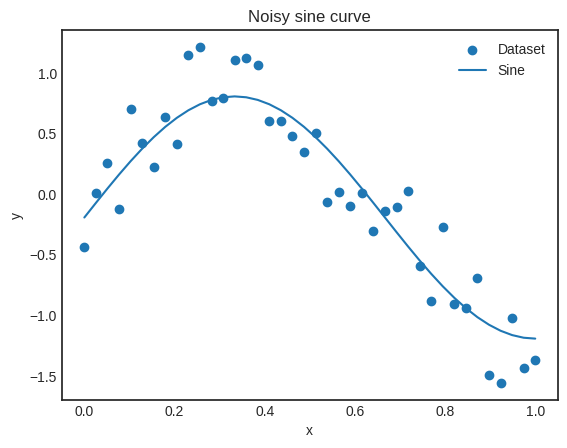

In [48]:
#Generating sine curve and uniform noise
x = np.linspace(0,1,40)
noise = 1*np.random.uniform(  size = 40)
y = np.sin(x * 1.5 * np.pi ) 
y_noise = (y + noise).reshape(-1,1)

#Centering the y data
y_noise = y_noise - y_noise.mean()

#Design matrix is x, x^2
X = np.vstack((2*x,x**2)).T

#Nornalizing the design matrix to facilitate visualization
X = X / np.linalg.norm(X,axis = 0)

#Plotting the result
plt.scatter(x,y_noise, label = 'Dataset')
plt.plot(x,y - y.mean(),label = 'Sine')
plt.title('Noisy sine curve')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def plot_gradient_descent_ridge(X, y_noise, regularized_mse, gradient_descent_reg, initial_theta, learning_rate, l, num_iters):
    """
    Plots the cost function surface and the path of gradient descent for ridge regularization.

    Parameters:
    X (numpy.ndarray): The input feature matrix.
    y_noise (numpy.ndarray): The noisy output/target values.
    regularized_mse (function): Function to compute the regularized mean squared error.
    gradient_descent_reg (function): Function to perform gradient descent with regularization.
    initial_theta (numpy.ndarray): Initial values for the theta parameters.
    learning_rate (float): The learning rate for gradient descent.
    l (float): The regularization parameter.
    num_iters (int): The number of iterations for gradient descent.

    Returns:
    None
    """
    
    # Setup of meshgrid of theta values
    T1, T2 = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))

    # Computing the cost function for each theta combination
    zs = np.array([regularized_mse(X, y_noise.reshape(-1, 1), np.array([t1, t2]).reshape(-1, 1), l) 
                   for t1, t2 in zip(np.ravel(T1), np.ravel(T2))])
    # Reshaping the cost values
    Z = zs.reshape(T1.shape)

    # Computing the gradient descent
    theta_result_reg, J_history_reg, theta_0, theta_1 = gradient_descent_reg(
        X, y_noise, initial_theta, learning_rate, l, num_iters
    )

    # Angles needed for quiver plot
    anglesx = np.array(theta_0)[1:] - np.array(theta_0)[:-1]
    anglesy = np.array(theta_1)[1:] - np.array(theta_1)[:-1]

    # Plotting
    fig = plt.figure(figsize=(16, 8))

    # Surface plot
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_surface(T1, T2, Z, rstride=5, cstride=5, cmap='jet', alpha=0.5)
    ax.plot(theta_0, theta_1, J_history_reg, marker='*', color='r', alpha=0.4, label='Gradient descent')

    ax.set_xlabel('theta 1')
    ax.set_ylabel('theta 2')
    ax.set_zlabel('error')
    ax.set_title('RSS gradient descent: Root at {}'.format(theta_result_reg.ravel()))
    ax.view_init(45, -45)

    # Contour plot
    ax = fig.add_subplot(1, 2, 2)
    ax.contour(T1, T2, Z, 100, cmap='jet')
    ax.quiver(theta_0[:-1], theta_1[:-1], anglesx, anglesy, scale_units='xy', angles='xy', scale=1, color='r', alpha=0.9)
    ax.set_xlabel('theta 1')
    ax.set_ylabel('theta 2')

    plt.suptitle('Cost function and gradient descent: Ridge regularization')
    plt.show()



In [50]:
import numpy as np
import matplotlib.pyplot as plt


# Regularization parameter
l = 10

# Setup of meshgrid of theta values
T1, T2 = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))

# Computing the cost function for each theta combination
zs = np.array([regularized_mse(X, y_noise.reshape(-1, 1), np.array([t1, t2]).reshape(-1, 1), l) 
               for t1, t2 in zip(np.ravel(T1), np.ravel(T2))])

# Reshaping the cost values
Z = zs.reshape(T1.shape)

# Computing the gradient descent
theta_result_reg, J_history_reg, theta_0, theta_1 = gradient_descent_reg(
    X, y_noise, np.array([7., 10.]).reshape(-1, 1), 0.8, l, num_iters=5000
)


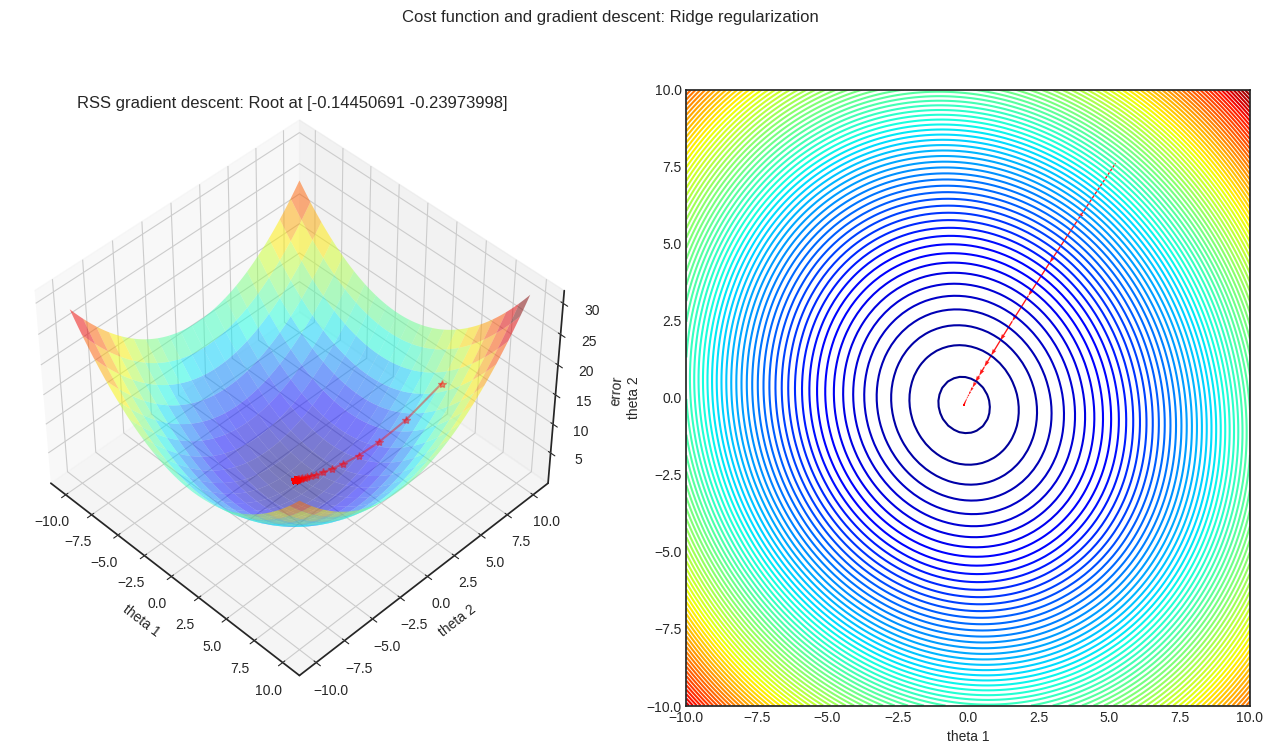

In [51]:
initial_theta = np.array([7., 10.]).reshape(-1, 1)
plot_gradient_descent_ridge(X, y_noise, regularized_mse, gradient_descent_reg, initial_theta, 0.8, 10, 5000)